In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import expm
from collections import deque
import random
import torch.nn.functional as F

In [2]:
np.random.seed(40)
torch.manual_seed(40)

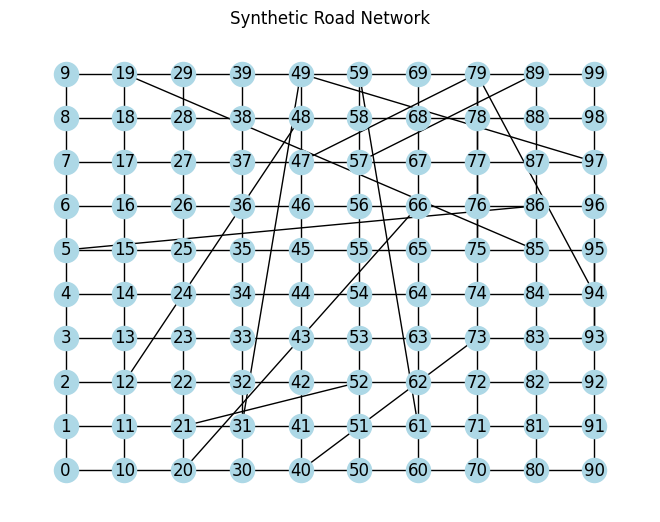

In [3]:
# Cell 2: Create a Synthetic Graph (Grid + Random Edges)
def create_graph(n_rows=4, n_cols=5, extra_edges=3):
    G = nx.grid_2d_graph(n_rows, n_cols)
    # Convert nodes to integer labels for easier indexing
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
    pos = {i: node for node, i in mapping.items()}
    
    # Add a few random extra edges for realism
    nodes = list(G.nodes())
    for _ in range(extra_edges):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    return G, pos

G, pos = create_graph(n_rows=10, n_cols=10, extra_edges=15)
num_nodes = G.number_of_nodes()
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.title("Synthetic Road Network")
plt.show()


In [4]:
# Cell 3: Generate Path Dataset (OD pairs + Paths)
def find_paths(G, num_paths=100, max_length=10):
    nodes = list(G.nodes())
    paths = []
    for _ in range(num_paths):
        while True:
            ori, dst = np.random.choice(nodes, 2, replace=False)
            try:
                path = nx.shortest_path(G, ori, dst)
                # Optionally add detours for realism
                if len(path) > 3 and np.random.rand() < 0.3:
                    # Insert a random neighbor somewhere in the path
                    idx = np.random.randint(1, len(path)-1)
                    neighbors = list(G.neighbors(path[idx]))
                    neighbors = [n for n in neighbors if n not in path]
                    if neighbors:
                        path = path[:idx+1] + [neighbors[0]] + path[idx+1:]
                if 3 < len(path) <= max_length:
                    paths.append((ori, dst, path))
                    break
            except nx.NetworkXNoPath:
                continue
    return paths

paths = find_paths(G, num_paths=1000, max_length=20)
print(f"Generated {len(paths)} OD-path samples.")


Generated 1000 OD-path samples.


In [5]:
# Cell 4: Node Embeddings (One-hot or Learnable)
# For simplicity, use learnable embeddings (like Node2Vec, but random init)
num_nodes = G.number_of_nodes()
embedding_dim = 8
node_embeddings = nn.Embedding(num_nodes, embedding_dim)


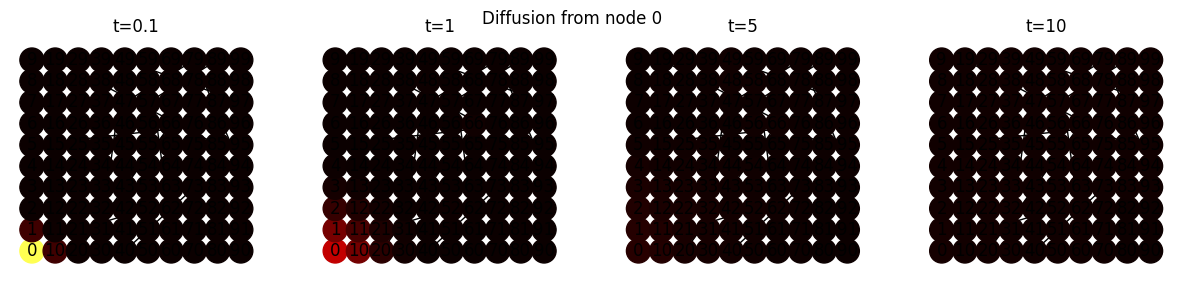

In [6]:
# Cell 5: Heat Kernel Diffusion - Transition Matrix
def compute_heat_kernel(G, t=1.0):
    A = nx.to_numpy_array(G)
    D = np.diag([G.degree(i) for i in range(num_nodes)])
    L = A - D
    C = expm(t * L)
    # Normalize rows to sum to 1 (probabilities)
    C = C / C.sum(axis=1, keepdims=True)
    return C

# Visualize diffusion from a single node
def plot_diffusion(C, node, steps=[0.1, 1, 5, 10]):
    fig, axs = plt.subplots(1, len(steps), figsize=(15, 3))
    for i, t in enumerate(steps):
        Ct = compute_heat_kernel(G, t)
        p = np.zeros(num_nodes)
        p[node] = 1
        p = p @ Ct
        nx.draw(G, pos, node_color=p, cmap='hot', vmin=0, vmax=1, ax=axs[i], with_labels=True)
        axs[i].set_title(f"t={t}")
    plt.suptitle(f"Diffusion from node {node}")
    plt.show()

plot_diffusion(compute_heat_kernel(G), node=0)

In [7]:
# Cell 6: Forward Diffusion Process for a Path
def diffuse_path(path, t):
    C = compute_heat_kernel(G, t)
    noisy_path = []
    for node in path:
        p = np.zeros(num_nodes)
        p[node] = 1
        p = p @ C
        noisy_node = np.random.choice(num_nodes, p=p)
        noisy_path.append(noisy_node)
    return noisy_path

# Visualize a diffused path
ori, dst, path = paths[0]
noisy_path = diffuse_path(path, t=2.0)
print("Original:", path)
print("Noisy:", noisy_path)


Original: [72, 62, 63, 64, 65]
Noisy: [50, 70, 52, 74, 83]


In [8]:
def beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=20, t=2.0):
    model.eval()
    beams = [[ori]]
    dst_pos = [pos[dst]]
    for step in range(max_len-1):
        new_beams = []
        for path in beams:
            noisy_path = diffuse_path(path, t)
            pad_len = max_len - len(noisy_path)
            noisy_path_tensor = torch.LongTensor([noisy_path + [0]*pad_len])
            mask = torch.BoolTensor([[1]*len(noisy_path) + [0]*pad_len])
            ori_tensor = torch.LongTensor([ori])
            dst_tensor = torch.LongTensor([dst])
            t_tensor = torch.FloatTensor([t])
            with torch.no_grad():
                logits = model(noisy_path_tensor, t_tensor, ori_tensor, dst_tensor, mask, pos, dst_pos)
                probs = torch.softmax(logits[0, len(path)-1], dim=-1).cpu().numpy()
            current = path[-1]
            neighbors = list(G.neighbors(current)) + [dst]
            mask_arr = np.zeros(num_nodes)
            mask_arr[neighbors] = 1
            probs = probs * mask_arr
            probs = probs / probs.sum()
            topk = np.argsort(probs)[-beam_width:]
            for n in topk:
                if probs[n] > 0:
                    new_beams.append(path + [n])
        # Keep only top beam_width beams by cumulative probability
        scored_beams = []
        for b in new_beams:
            # Score: product of transition probabilities for last step
            score = 1.0
            for i in range(1, len(b)):
                if G.has_edge(b[i-1], b[i]) or b[i] == dst:
                    score *= 1.0  # Optionally use probs[b[i]] for finer scoring
                else:
                    score *= 0.0
            scored_beams.append((score, b))
        scored_beams = sorted(scored_beams, key=lambda x: -x[0])[:beam_width]
        beams = [b for s, b in scored_beams if s > 0]
        if any(b[-1] == dst for b in beams):
            # Return the first complete path
            for b in beams:
                if b[-1] == dst:
                    return b
    # If no path reaches dst, return best partial beam
    return beams[0] if beams else [ori]


In [9]:
class ReverseDiffusionModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim, hidden_dim=64, n_heads=2):
        super().__init__()
        self.embedding = node_embeddings  # Share embeddings
        self.t_embed = nn.Linear(1, hidden_dim)
        self.OD_embed = nn.Linear(2 * embedding_dim, hidden_dim)
        self.spatial_fc = nn.Linear(2, hidden_dim)  # For [distance, direction]
        self.attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=n_heads, batch_first=True)
        self.conv1 = nn.Conv1d(embedding_dim + hidden_dim * 3, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, noisy_path, t, ori, dst, mask, pos, dst_pos):
        # noisy_path: [batch, path_len]
        batch_size, path_len = noisy_path.shape
        node_embs = self.embedding(noisy_path)  # [batch, path_len, emb]

        # Self-attention over the path sequence
        attn_out, _ = self.attn(node_embs, node_embs, node_embs, key_padding_mask=~mask)
        
        # Spatial features: distance and direction to destination
        spatial_feats = []
        for b in range(batch_size):
            feats = []
            for i in range(path_len):
                n = noisy_path[b, i].item()
                node_xy = np.array(pos[n])
                dst_xy = np.array(dst_pos[b])
                dist = np.linalg.norm(node_xy - dst_xy)
                direction = 0.0
                if np.linalg.norm(node_xy - dst_xy) > 1e-6:
                    direction = np.dot((dst_xy - node_xy), [1,0]) / (np.linalg.norm(dst_xy - node_xy) + 1e-8)
                feats.append([dist, direction])
            spatial_feats.append(feats)
        spatial_feats = torch.tensor(spatial_feats, dtype=torch.float32, device=node_embs.device)
        spatial_embs = self.spatial_fc(spatial_feats)  # [batch, path_len, hidden_dim]
        
        t_emb = self.t_embed(t.view(-1, 1)).unsqueeze(1).repeat(1, path_len, 1)
        OD_emb = self.OD_embed(torch.cat([self.embedding(ori), self.embedding(dst)], dim=-1)).unsqueeze(1).repeat(1, path_len, 1)
        
        x = torch.cat([attn_out, t_emb, OD_emb, spatial_embs], dim=-1).permute(0, 2, 1)  # [batch, emb+..., path_len]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # [batch, path_len, hidden]
        logits = self.fc(x)  # [batch, path_len, num_nodes]
        return logits


In [10]:
def prepare_batch(paths, pos, batch_size=16):
    batch = random.sample(paths, batch_size)
    max_len = max(len(p[2]) for p in batch)
    noisy_paths, clean_paths, oris, dsts, ts, masks, dst_pos = [], [], [], [], [], [], []
    for ori, dst, path in batch:
        t = np.random.uniform(0.1, 5.0)
        noisy = diffuse_path(path, t)
        pad_len = max_len - len(path)
        noisy += [0]*pad_len
        path += [0]*pad_len
        mask = [1]* (len(path)-pad_len) + [0]*pad_len
        noisy_paths.append(noisy)
        clean_paths.append(path)
        oris.append(ori)
        dsts.append(dst)
        ts.append(t)
        masks.append(mask)
        dst_pos.append(pos[dst])
    return (torch.LongTensor(noisy_paths),
            torch.LongTensor(clean_paths),
            torch.LongTensor(oris),
            torch.LongTensor(dsts),
            torch.FloatTensor(ts),
            torch.BoolTensor(masks),
            dst_pos)

model = ReverseDiffusionModel(num_nodes, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    noisy_paths, clean_paths, oris, dsts, ts, masks, dst_pos = prepare_batch(paths, pos, batch_size=32)
    logits = model(noisy_paths, ts, oris, dsts, masks, pos, dst_pos)
    # Mask out padded positions in loss
    logits = logits.view(-1, num_nodes)
    clean_paths = clean_paths.view(-1)
    masks_flat = masks.view(-1)
    loss = loss_fn(logits[masks_flat], clean_paths[masks_flat])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 4.6236
Epoch 5, Loss: 4.4038
Epoch 10, Loss: 4.1700
Epoch 15, Loss: 3.7917
Epoch 20, Loss: 3.7475
Epoch 25, Loss: 3.5785
Epoch 30, Loss: 3.3083
Epoch 35, Loss: 3.3349
Epoch 40, Loss: 3.4514
Epoch 45, Loss: 3.1250
Epoch 50, Loss: 2.9938
Epoch 55, Loss: 3.0761
Epoch 60, Loss: 3.0119
Epoch 65, Loss: 3.0244
Epoch 70, Loss: 3.2407
Epoch 75, Loss: 2.9540
Epoch 80, Loss: 2.8052
Epoch 85, Loss: 2.8305
Epoch 90, Loss: 2.7068
Epoch 95, Loss: 2.8154
Epoch 100, Loss: 2.9759
Epoch 105, Loss: 2.7775
Epoch 110, Loss: 2.5566
Epoch 115, Loss: 2.7928
Epoch 120, Loss: 2.7976
Epoch 125, Loss: 2.6700
Epoch 130, Loss: 2.7313
Epoch 135, Loss: 2.7131
Epoch 140, Loss: 2.4484
Epoch 145, Loss: 2.5335
Epoch 150, Loss: 2.9138
Epoch 155, Loss: 2.5808
Epoch 160, Loss: 2.5568
Epoch 165, Loss: 2.5854
Epoch 170, Loss: 2.6235
Epoch 175, Loss: 2.4807
Epoch 180, Loss: 2.5503
Epoch 185, Loss: 2.4318
Epoch 190, Loss: 2.3945
Epoch 195, Loss: 2.6884
Epoch 200, Loss: 2.5582
Epoch 205, Loss: 2.4678
Epoch 210, Los

Planned path: [28, 11]


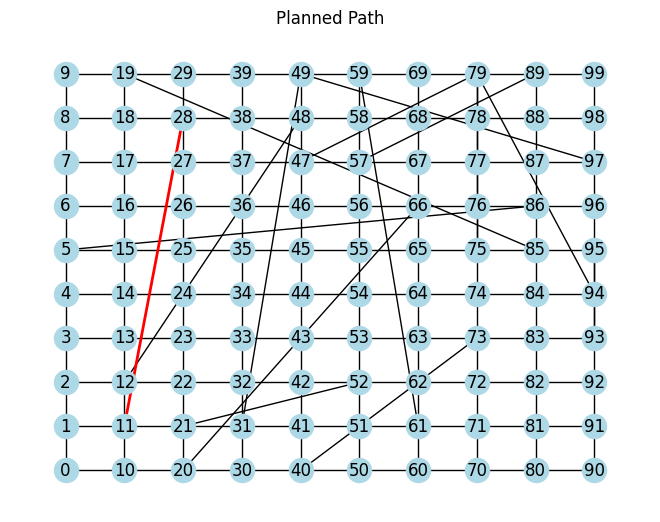

In [11]:
def conditional_plan(model, G, ori, dst, pos, max_len=8, t=2.0):
    model.eval()
    path = [ori]
    dst_pos = [pos[dst]]
    for step in range(max_len-1):
        noisy_path = diffuse_path(path, t)
        pad_len = max_len - len(noisy_path)
        noisy_path_tensor = torch.LongTensor([noisy_path + [0]*pad_len])
        mask = torch.BoolTensor([[1]*len(noisy_path) + [0]*pad_len])
        ori_tensor = torch.LongTensor([ori])
        dst_tensor = torch.LongTensor([dst])
        t_tensor = torch.FloatTensor([t])
        with torch.no_grad():
            logits = model(noisy_path_tensor, t_tensor, ori_tensor, dst_tensor, mask, pos, dst_pos)
            probs = torch.softmax(logits[0, len(path)-1], dim=-1).cpu().numpy()
        current = path[-1]
        neighbors = list(G.neighbors(current)) + [dst]
        mask_arr = np.zeros(num_nodes)
        mask_arr[neighbors] = 1
        probs = probs * mask_arr
        probs = probs / probs.sum()
        next_node = np.random.choice(num_nodes, p=probs)
        path.append(next_node)
        if next_node == dst:
            break
    return path

# Example: Plan a path from ori to dst
ori, dst, _ = random.choice(paths)
planned_path = beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=20)
print("Planned path:", planned_path)

# Visualize
def plot_path(G, pos, path, color='r', label='Planned'):
    nx.draw(G, pos, with_labels=True, node_color='lightblue')
    edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2, label=label)
    plt.title(label)
    plt.show()

plot_path(G, pos, planned_path, color='r', label='Planned Path')


In [12]:
# Cell 10: Evaluation (DTW, LCS, Hit Ratio)
from difflib import SequenceMatcher

def lcs(a, b):
    matcher = SequenceMatcher(None, a, b)
    return matcher.find_longest_match(0, len(a), 0, len(b)).size

def dtw(a, b):
    n, m = len(a), len(b)
    dp = np.full((n+1, m+1), float('inf'))
    dp[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i, j] = cost + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
    return dp[n, m]

# Evaluate on a sample
hits = []
lcs_scores = []
dtw_scores = []
for i in range(20):
    ori, dst, gt_path = random.choice(paths)
    pred_path = conditional_plan(model, G, ori, dst, pos)
    hit = (pred_path[-1] == dst)
    hits.append(hit)
    lcs_scores.append(lcs(gt_path, pred_path))
    dtw_scores.append(dtw(gt_path, pred_path))
print(f"Hit ratio: {np.mean(hits):.2f}, Avg LCS: {np.mean(lcs_scores):.2f}, Avg DTW: {np.mean(dtw_scores):.2f}")


Hit ratio: 0.80, Avg LCS: 1.40, Avg DTW: 8.95
